# Modelos y matrices de correlación incorporando ajustes y mejoras del primero 

In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pytensor  
from patsy import dmatrix


In [2]:
# read data
df = pd.read_csv("../data/clean/clean2_final_nutricion_salud.csv")

---

In [3]:
# Filtramos observaciones con datos completos de talla, edad y sexo
df_model = df[["talla_cm", "edad_anios_calc", "sexo", "peso_kg", "municipio", "id_persona"]].dropna()

# Establecemos 'id_persona' como índice del DataFrame
df_model = df_model.set_index("id_persona")

# Codificamos correctamente sexo 
# Recodeamos sexo: 0 = mujer, 1 = hombre
df_model["sexo"] = df_model["sexo"].map({2: 0, 1: 1})

# Confirmamos los tipos de variables y que no haya NAs
df_model.info()
df_model.describe()
df_model["sexo"].value_counts()
df_model["municipio"].nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 25355 entries, 100001_3 to 70336_4
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   talla_cm         25355 non-null  float64
 1   edad_anios_calc  25355 non-null  float64
 2   sexo             25355 non-null  int64  
 3   peso_kg          25355 non-null  float64
 4   municipio        25355 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.2+ MB


177

In [4]:
# Codificamos cada municipio con un índice entero único (de 0 a n_grupos - 1)
df_model["municipio_idx"] = pd.Categorical(df_model["municipio"]).codes

# Verificamos que se creó correctamente
df_model[["municipio", "municipio_idx"]].drop_duplicates().sort_values("municipio_idx").head()


,municipio,municipio_idx
id_persona,,
100001_3,1.0,0
11276_3,2.0,1
110044_5,3.0,2
100075_5,4.0,3
100121_6,5.0,4


---

In [5]:
# Centrar la edad y guardar la media: 
# Esto ayuda a que el intercepto sea interpretable (talla promedio en la edad media) y mejora la estabilidad numérica del muestreo.
edad_mean = df_model["edad_anios_calc"].mean()
df_model["edad_c"] = df_model["edad_anios_calc"] - edad_mean

print(f"Edad media en la muestra: {edad_mean:.3f} años")
df_model[["edad_anios_calc", "edad_c"]].head()


Edad media en la muestra: 6.266 años


,edad_anios_calc,edad_c
id_persona,,
100001_3,8.695414,2.429254
100006_6,11.211499,4.945339
100008_10,7.561944,1.295784
100009_3,6.277892,0.011732
100010_7,8.145106,1.878946


---

## Quinto Modelo: Splines: M4 con splines

In [6]:
# Construcción de B-splines cúbicos para la edad
# (A) Hiperparámetro de flexibilidad
df_spline = 5        # Empezamos con 5; luego probamos 6 o 7 si hace falta.

# (B) Matriz de B-splines cúbicos de la edad (sin intercepto)
X_spline = dmatrix(
    "bs(edad, df=df_spline, degree=3, include_intercept=False) - 1",
    {"edad": df_model["edad_anios_calc"].values},
    return_type="dataframe"
)

# (C) A NumPy para PyMC
X_s = X_spline.to_numpy()

# (D) Chequeo rápido
n_obs, n_s = X_s.shape
print("X_s shape:", X_s.shape)   # (n_obs, n_bases)


X_s shape: (25355, 5)


In [7]:
# Variable objetivo y predictores “clásicos”
y        = df_model["talla_cm"].to_numpy()
sexo     = df_model["sexo"].to_numpy().astype(int)  # 0 = mujer, 1 = hombre

# Edad centrada (importante para estabilidad y para interpretar el intercepto)
edad_c   = (df_model["edad_anios_calc"] - df_model["edad_anios_calc"].mean()).to_numpy()

# Índice entero de municipio por observación (0..n_muni-1)
muni_idx = df_model["municipio_idx"].to_numpy().astype(int)

# Tamaños
n_obs_chk = y.shape[0]
n_muni    = int(muni_idx.max()) + 1

# Chequeos
assert X_s.shape[0] == n_obs_chk, "X_s debe tener tantas filas como observaciones."
print(f"n_obs={n_obs_chk} | n_s(bases)={n_s} | n_muni={n_muni}")


n_obs=25355 | n_s(bases)=5 | n_muni=177


In [8]:

with pm.Model() as modelo_m5:
    # --- Priors globales (cm) ---
    beta_0        = pm.Normal("beta_0", 125, 10)     # talla a la edad media (sexo=0)
    beta_sexo     = pm.Normal("beta_sexo", 3, 2)     # diferencia nivel hombre vs mujer
    beta_edad_sex = pm.Normal("beta_edad_sex", 0, 2) # interacción lineal edad_c × sexo (opcional)

    # --- Pesos de las bases spline (regularización suave) ---
    # Normal(0,1) ≈ “ridge” suave; si vemos curvas muy onduladas, bajamos a 0.5
    w_s = pm.Normal("w_s", 0, 1.0, shape=n_s)

    # --- Efectos aleatorios por municipio (no-centrados) ---
    sd_a0 = pm.HalfNormal("sd_a0", 5)   # sd de interceptos municipales (cm)
    sd_a1 = pm.HalfNormal("sd_a1", 2)   # sd de pendientes municipales (cm/año)

    z_a0 = pm.Normal("z_a0", 0, 1, shape=n_muni) # de la centralización
    z_a1 = pm.Normal("z_a1", 0, 1, shape=n_muni) # de la centralización
    a0   = pm.Deterministic("a0", sd_a0 * z_a0) 
    a1   = pm.Deterministic("a1", sd_a1 * z_a1)

    # --- Curva de edad a partir de las bases ---
    # dot(X_s, w_s): vector (n_obs,) con la contribución no lineal de la edad
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s, w_s))

    # --- Media (predicción) ---
    mu = (
        beta_0
        + beta_sexo * sexo
        + f_edad                        # curva suave común por edad
        + a0[muni_idx]                  # nivel municipal
        + a1[muni_idx] * edad_c         # “tilt” lineal municipal
        + beta_edad_sex * (edad_c * sexo)  # opcional: diferencia de pendiente global por sexo
    )

    # --- Likelihood robusta ---
    nu    = pm.Exponential("nu", 1/10)     # g.l. (media 10)
    sigma = pm.HalfNormal("sigma_obs", 5)  # escala residual (cm)
    talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y)


Por qué “no centrado” en a0, a1:

Cuando la variación entre municipios (sd_a*) es pequeña o el muestreo está “tenso”, la forma no centrada (z ~ N(0,1); a = sd*z) mejora mucho la mezcla y reduce divergencias.

In [9]:
with modelo_m5:
    idata_m5 = pm.sample(
        draws=1000, tune=1000,          # empezamos moderado; si todo OK luego subimos a 1200–1500
        chains=4, cores=1,            # cores=1 evita issues en notebooks/entornos limitados
        target_accept=0.97,           # alto = menos divergences (si hay, subimos a 0.99)
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

    # PPC (para plot_ppc y checks)
    ppc_m5 = pm.sample_posterior_predictive(idata_m5, return_inferencedata=True, random_seed=42)
    idata_m5.extend(ppc_m5)   # <- sin reasignar

    print(idata_m5.groups())


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, beta_sexo, beta_edad_sex, w_s, sd_a0, sd_a1, z_a0, z_a1, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8864 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

['posterior', 'posterior_predictive', 'log_likelihood', 'sample_stats', 'observed_data']


In [10]:
summ = az.summary(idata_m5, round_to=2)
display(summ.head(12))

/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,106.29,0.38,105.57,106.98,0.01,0.01,1062.07,1766.21,1.00
beta_sexo,0.48,0.07,0.36,0.61,0.00,0.00,6941.20,3220.83,1.00
beta_edad_sex,-0.24,0.02,-0.28,-0.20,0.00,0.00,7198.10,2839.70,1.00
w_s[0],10.42,0.36,9.76,11.11,0.01,0.01,3697.20,2967.67,1.00
w_s[1],10.58,0.30,10.00,11.13,0.01,0.00,1739.15,2898.88,1.00
w_s[2],3.95,0.50,3.02,4.88,0.01,0.01,1378.66,2417.37,1.00
w_s[3],-1.13,0.62,-2.33,0.01,0.02,0.01,1421.18,2399.10,1.00
w_s[4],-4.53,0.67,-5.76,-3.25,0.02,0.01,1404.64,2029.01,1.00
z_a0[0],0.75,0.14,0.50,1.01,0.00,0.00,757.12,1984.11,1.01
z_a0[1],0.51,0.14,0.26,0.78,0.00,0.00,899.73,1877.99,1.00


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/2900665297.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)  # (n_obs, 2)


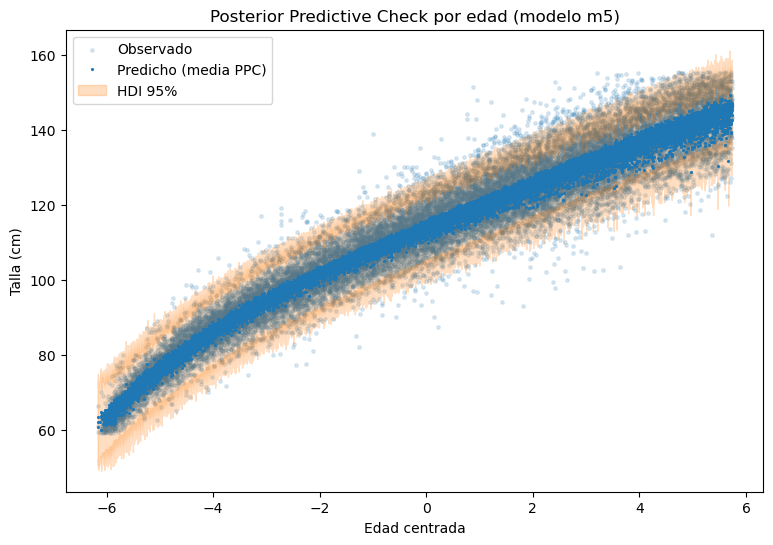

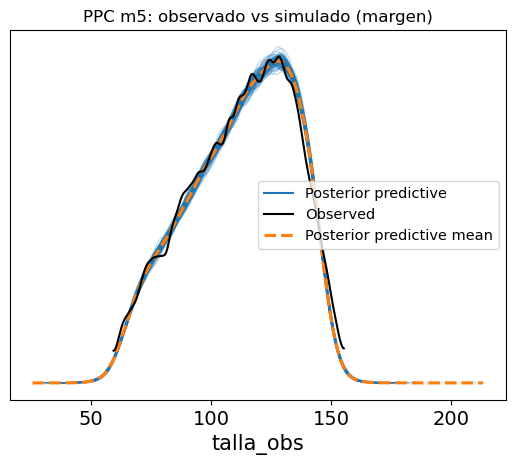

In [13]:

# === Extraer simulaciones PPC ===
y_ppc = idata_m5.posterior_predictive["talla_obs"].stack(sample=("chain","draw")).values.T  
# shape: (n_samples, n_obs)

# === Calcular media y bandas de credibilidad por observación ===
y_ppc_mean = y_ppc.mean(axis=0)
y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)  # (n_obs, 2)

# === Ordenar por edad centrada ===
ord = np.argsort(edad_c)

# === Graficar ===
plt.figure(figsize=(9,6))
plt.scatter(edad_c, y, s=6, alpha=0.15, label="Observado")
plt.plot(edad_c[ord], y_ppc_mean[ord], ".", ms=2.5, label="Predicho (media PPC)")

# Banda de credibilidad
plt.fill_between(
    edad_c[ord],
    y_ppc_hdi[:,0][ord],
    y_ppc_hdi[:,1][ord],
    color="C1", alpha=0.25, label="HDI 95%"
)

plt.xlabel("Edad centrada")
plt.ylabel("Talla (cm)")
plt.title("Posterior Predictive Check por edad (modelo m5)")
plt.legend()
plt.show()

# === PPC margen: observado vs simulado ===

az.plot_ppc(
    idata_m5,
    var_names=["talla_obs"],   # <- aquí indicas la variable observada/simulada
    num_pp_samples=100,        # número de simulaciones a mostrar
    kind="kde",                # densidad suave; también puedes usar "hist"
    alpha=0.3
)

plt.title("PPC m5: observado vs simulado (margen)")
plt.show()




---

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, beta_sexo, beta_edad_sex, w_s, sd_a0, sd_a1, z_a0, z_a1, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40980 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

                  mean     sd   hdi_3%  hdi_97%
beta_0         106.242  0.365  105.558  106.939
beta_sexo        0.479  0.066    0.359    0.609
beta_edad_sex   -0.235  0.020   -0.273   -0.198
sd_a0            1.509  0.115    1.310    1.730
sd_a1            6.700  0.288    6.209    7.286
...                ...    ...      ...      ...
z_a1[172]        1.051  0.058    0.947    1.166
z_a1[173]        1.174  0.084    1.017    1.337
z_a1[174]        1.134  0.094    0.953    1.304
z_a1[175]        1.143  0.066    1.022    1.271
z_a1[176]        1.181  0.076    1.039    1.323

[359 rows x 4 columns]


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/1876634105.py:78: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)


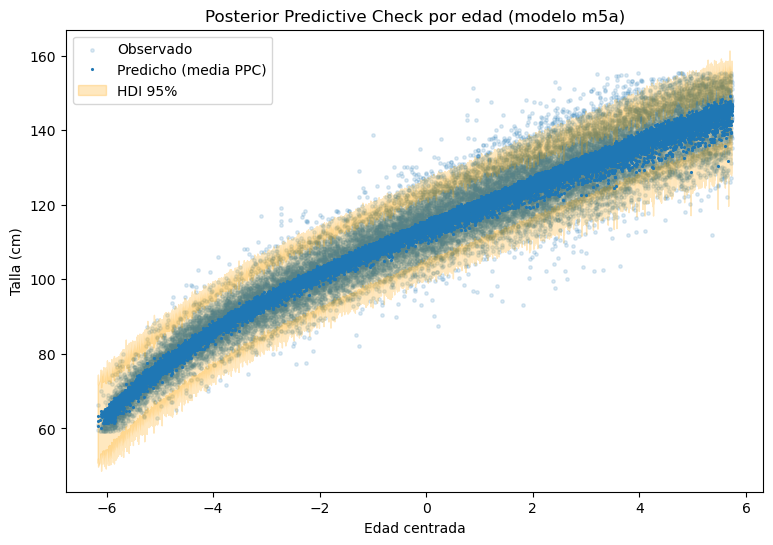

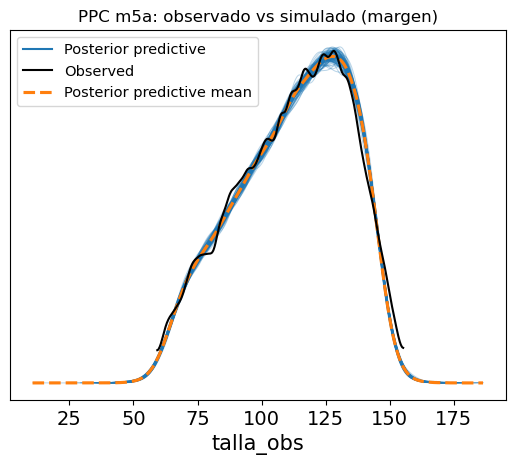

In [14]:
# ==============================
# Modelo jerárquico bayesiano (m5a)
# ==============================
with pm.Model() as modelo_m5a:
    # --- Priors globales (cm) ---
    beta_0        = pm.Normal("beta_0", 125, 10)     # talla a edad media (sexo=0)
    beta_sexo     = pm.Normal("beta_sexo", 3, 2)     # diferencia nivel hombre vs mujer
    beta_edad_sex = pm.Normal("beta_edad_sex", 0, 2) # interacción lineal edad_c × sexo (opcional)

    # --- Pesos de las bases spline (regularización suave) ---
    w_s = pm.Normal("w_s", 0, 1.0, shape=n_s)

    # --- Efectos aleatorios por municipio (no-centrados) ---
    sd_a0 = pm.HalfNormal("sd_a0", 2.5)   # sd de interceptos municipales (cm)
    sd_a1 = pm.HalfNormal("sd_a1", 1.0)   # sd de pendientes municipales (cm/año)

    z_a0 = pm.Normal("z_a0", 0, 1, shape=n_muni)
    z_a1 = pm.Normal("z_a1", 0, 1, shape=n_muni)

    a0   = pm.Deterministic("a0", sd_a0 * z_a0) 
    a1   = pm.Deterministic("a1", sd_a1 * z_a1)

    # --- Curva de edad a partir de las bases ---
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s, w_s))

    # --- Media (predicción) ---
    mu = (
        beta_0
        + beta_sexo * sexo
        + f_edad
        + a0[muni_idx]
        + a1[muni_idx] * edad_c
        + beta_edad_sex * (edad_c * sexo)
    )

    # --- Likelihood robusta ---
    nu    = pm.Exponential("nu", 1/10)     
    sigma = pm.HalfNormal("sigma_obs", 5)  
    talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y)

    # ==============================
    # Muestreo
    # ==============================
    idata_m5a = pm.sample(
        draws=2000, tune=2000,
        chains=4, cores=1,
        target_accept=0.99,
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

    # ==============================
    # PPC
    # ==============================
    ppc_m5a = pm.sample_posterior_predictive(
        idata_m5a, return_inferencedata=True, random_seed=42
    )
    idata_m5a.extend(ppc_m5a)


# ==============================
# Resumen diagnóstico
# ==============================
print(az.summary(
    idata_m5a, 
    var_names=["beta_0","beta_sexo","beta_edad_sex","sd_a0","sd_a1","z_a0","z_a1"],
    kind="stats"
))


# ==============================
# PPC por edad
# ==============================
y_ppc = idata_m5a.posterior_predictive["talla_obs"].stack(sample=("chain","draw")).values.T
y_ppc_mean = y_ppc.mean(axis=0)
y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)

ord = np.argsort(edad_c)

plt.figure(figsize=(9,6))
plt.scatter(edad_c, y, s=6, alpha=0.15, label="Observado")
plt.plot(edad_c[ord], y_ppc_mean[ord], ".", ms=2.5, label="Predicho (media PPC)")
plt.fill_between(
    edad_c[ord],
    y_ppc_hdi[:,0][ord],
    y_ppc_hdi[:,1][ord],
    color="orange", alpha=0.25, label="HDI 95%"
)
plt.xlabel("Edad centrada")
plt.ylabel("Talla (cm)")
plt.title("Posterior Predictive Check por edad (modelo m5a)")
plt.legend()
plt.show()


# ==============================
# PPC marginal
# ==============================
az.plot_ppc(
    idata_m5a,
    var_names=["talla_obs"],
    num_pp_samples=100,
    kind="kde",
    alpha=0.3
)
plt.title("PPC m5a: observado vs simulado (margen)")
plt.show()


In [16]:
az.summary(idata_m5a, round_to=2)
display(summ.head(12))

/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,106.29,0.38,105.57,106.98,0.01,0.01,1062.07,1766.21,1.00
beta_sexo,0.48,0.07,0.36,0.61,0.00,0.00,6941.20,3220.83,1.00
beta_edad_sex,-0.24,0.02,-0.28,-0.20,0.00,0.00,7198.10,2839.70,1.00
w_s[0],10.42,0.36,9.76,11.11,0.01,0.01,3697.20,2967.67,1.00
w_s[1],10.58,0.30,10.00,11.13,0.01,0.00,1739.15,2898.88,1.00
w_s[2],3.95,0.50,3.02,4.88,0.01,0.01,1378.66,2417.37,1.00
w_s[3],-1.13,0.62,-2.33,0.01,0.02,0.01,1421.18,2399.10,1.00
w_s[4],-4.53,0.67,-5.76,-3.25,0.02,0.01,1404.64,2029.01,1.00
z_a0[0],0.75,0.14,0.50,1.01,0.00,0.00,757.12,1984.11,1.01
z_a0[1],0.51,0.14,0.26,0.78,0.00,0.00,899.73,1877.99,1.00


In [19]:
pd.set_option("display.max_rows", None)    # sin límite de filas
pd.set_option("display.max_columns", None) # sin límite de columnas
pd.set_option("display.width", None)       # ajuste de ancho automático

summary_m5a = az.summary(
    idata_m5a, 
    var_names=["beta_0","beta_sexo","beta_edad_sex","sd_a0","sd_a1","z_a0","z_a1"],
    kind="stats"
)
print(summary_m5a)



                  mean     sd   hdi_3%  hdi_97%
beta_0         106.242  0.365  105.558  106.939
beta_sexo        0.479  0.066    0.359    0.609
beta_edad_sex   -0.235  0.020   -0.273   -0.198
sd_a0            1.509  0.115    1.310    1.730
sd_a1            6.700  0.288    6.209    7.286
z_a0[0]          0.756  0.138    0.495    1.011
z_a0[1]          0.520  0.135    0.265    0.778
z_a0[2]          0.765  0.160    0.479    1.083
z_a0[3]          0.500  0.138    0.253    0.769
z_a0[4]          1.022  0.157    0.723    1.310
z_a0[5]          0.499  0.160    0.204    0.805
z_a0[6]          0.914  0.174    0.580    1.232
z_a0[7]          1.024  0.166    0.712    1.327
z_a0[8]          0.613  0.173    0.293    0.941
z_a0[9]          0.880  0.168    0.564    1.190
z_a0[10]         1.192  0.201    0.794    1.549
z_a0[11]         0.611  0.173    0.293    0.945
z_a0[12]         0.396  0.218    0.002    0.819
z_a0[13]         0.749  0.179    0.414    1.082
z_a0[14]         0.809  0.216    0.402  

---

En m5a los z_a1 se concentraban ~1, y que al imponer suma-cero + estandarizar edad, en m5b los z_a1 se recentran en 0 y sd_a1 queda interpretable (cm por 1 DE de edad).

In [20]:

# 1) estandarizar edad centrada
edad_z = (edad_c - np.mean(edad_c)) / np.std(edad_c)

with pm.Model() as modelo_m5b:
    # Priors globales
    beta_0        = pm.Normal("beta_0", 125, 10)
    beta_sexo     = pm.Normal("beta_sexo", 3, 2)
    beta_edad_sex = pm.Normal("beta_edad_sex", 0, 2)

    # Spline global
    w_s   = pm.Normal("w_s", 0, 1.0, shape=n_s)
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s, w_s))

    # Efectos aleatorios (no centrados)
    sd_a0 = pm.HalfNormal("sd_a0", 2.5)
    sd_a1 = pm.HalfNormal("sd_a1", 1.0)

    z_a0  = pm.Normal("z_a0", 0, 1, shape=n_muni)

    # --- suma-cero en pendientes municipales ---
    z_a1_raw = pm.Normal("z_a1_raw", 0, 1, shape=n_muni)
    z_a1     = pm.Deterministic("z_a1", z_a1_raw - pm.math.mean(z_a1_raw))

    a0 = pm.Deterministic("a0", sd_a0 * z_a0)
    a1 = pm.Deterministic("a1", sd_a1 * z_a1)

    # Media
    mu = (
        beta_0
        + beta_sexo * sexo
        + f_edad
        + a0[muni_idx]
        + a1[muni_idx] * edad_z         # usa edad estandarizada
        + beta_edad_sex * (edad_z * sexo)
    )

    # Likelihood robusta
    nu    = pm.Exponential("nu", 1/10)
    sigma = pm.HalfNormal("sigma_obs", 5)
    talla_obs = pm.StudentT("talla_obs", nu=nu, mu=mu, sigma=sigma, observed=y)

    # Muestreo
    idata_m5b = pm.sample(
        draws=2000, tune=2000,
        chains=4, cores=1,
        target_accept=0.99,
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

    # PPC
    ppc_m5b = pm.sample_posterior_predictive(idata_m5b, return_inferencedata=True, random_seed=42)
    idata_m5b.extend(ppc_m5b)

# Diagnóstico rápido (z_a1 debe recentrarse ≈ 0)
print(az.summary(idata_m5b, var_names=["sd_a0","sd_a1","z_a1","a1"], kind="stats").head(12))


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, beta_sexo, beta_edad_sex, w_s, sd_a0, sd_a1, z_a0, z_a1_raw, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 69658 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

           mean     sd  hdi_3%  hdi_97%
sd_a0     1.518  0.113   1.303    1.726
sd_a1    35.261  0.520  34.261   36.223
z_a1[0]   0.635  0.010   0.616    0.654
z_a1[1]   0.627  0.010   0.607    0.645
z_a1[2]   0.638  0.011   0.618    0.658
z_a1[3]   0.634  0.010   0.615    0.653
z_a1[4]   0.640  0.011   0.619    0.659
z_a1[5]   0.637  0.011   0.617    0.657
z_a1[6]   0.638  0.011   0.618    0.659
z_a1[7]   0.630  0.010   0.610    0.650
z_a1[8]   0.645  0.011   0.625    0.666
z_a1[9]   0.647  0.011   0.626    0.667


In [22]:
az.summary(idata_m5b, round_to=2)
display(summ.head(12))

/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,106.29,0.38,105.57,106.98,0.01,0.01,1062.07,1766.21,1.00
beta_sexo,0.48,0.07,0.36,0.61,0.00,0.00,6941.20,3220.83,1.00
beta_edad_sex,-0.24,0.02,-0.28,-0.20,0.00,0.00,7198.10,2839.70,1.00
w_s[0],10.42,0.36,9.76,11.11,0.01,0.01,3697.20,2967.67,1.00
w_s[1],10.58,0.30,10.00,11.13,0.01,0.00,1739.15,2898.88,1.00
w_s[2],3.95,0.50,3.02,4.88,0.01,0.01,1378.66,2417.37,1.00
w_s[3],-1.13,0.62,-2.33,0.01,0.02,0.01,1421.18,2399.10,1.00
w_s[4],-4.53,0.67,-5.76,-3.25,0.02,0.01,1404.64,2029.01,1.00
z_a0[0],0.75,0.14,0.50,1.01,0.00,0.00,757.12,1984.11,1.01
z_a0[1],0.51,0.14,0.26,0.78,0.00,0.00,899.73,1877.99,1.00


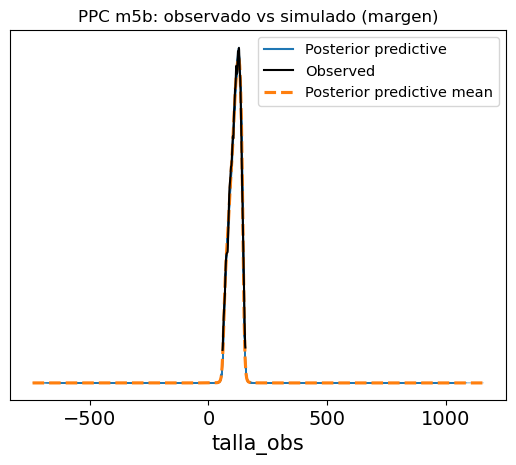

/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/2578807934.py:20: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)


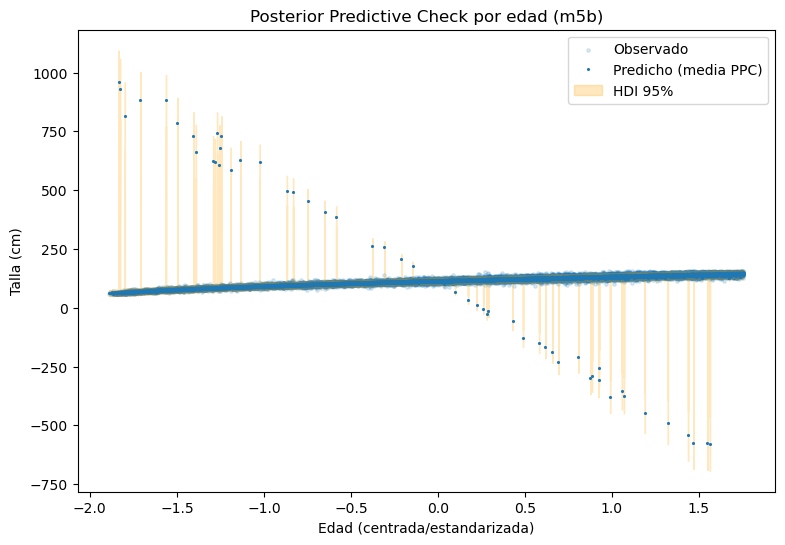

In [24]:

try:
    edad_b = edad_z
except NameError:
    edad_b = edad_c  # si no estandarizaste

# --- PPC marginal ---
az.plot_ppc(
    idata_m5b,
    var_names=["talla_obs"],
    num_pp_samples=100,
    kind="kde",
    alpha=0.3
)
plt.title("PPC m5b: observado vs simulado (margen)")
plt.show()

# --- PPC por edad (media + banda HDI) ---
y_ppc = idata_m5b.posterior_predictive["talla_obs"].stack(sample=("chain","draw")).values.T
y_ppc_mean = y_ppc.mean(axis=0)
y_ppc_hdi  = az.hdi(y_ppc, hdi_prob=0.95)

ord_ = np.argsort(edad_b)
plt.figure(figsize=(9,6))
plt.scatter(edad_b, y, s=6, alpha=0.15, label="Observado")
plt.plot(edad_b[ord_], y_ppc_mean[ord_], ".", ms=2.5, label="Predicho (media PPC)")
plt.fill_between(edad_b[ord_], y_ppc_hdi[:,0][ord_], y_ppc_hdi[:,1][ord_],
                 color="orange", alpha=0.25, label="HDI 95%")
plt.xlabel("Edad (centrada/estandarizada)"); plt.ylabel("Talla (cm)")
plt.title("Posterior Predictive Check por edad (m5b)")
plt.legend(); plt.show()


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/3450830390.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_ppc_m, hdi_prob=hdi_prob)
/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/3450830390.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_ppc_m, hdi_prob=hdi_prob)
/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/3450830390.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_ppc_m, hdi_prob=hdi_prob)
/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/3450830390.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but 

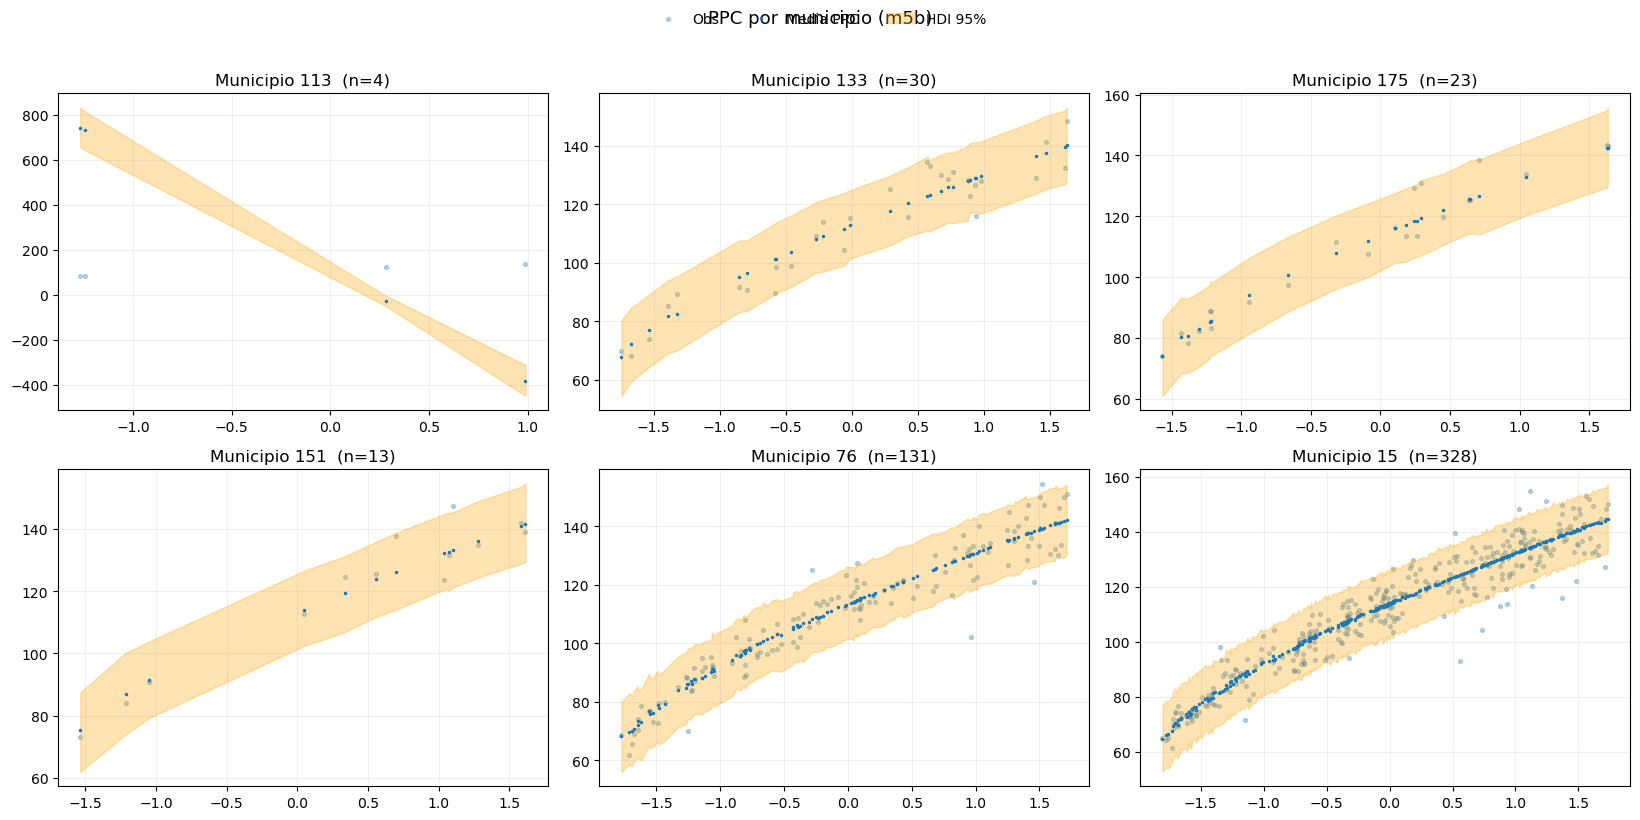

In [ ]:
# Función para graficar PPC por municipios específicos o aleatorios
def ppc_municipios(idata, y, edad, muni_idx, munis=None, n_random=6, hdi_prob=0.95, seed=42):
    rng = np.random.default_rng(seed)
    if munis is None:
        uniq = np.unique(muni_idx)
        munis = rng.choice(uniq, size=min(n_random, len(uniq)), replace=False)

    y_ppc = idata.posterior_predictive["talla_obs"].stack(sample=("chain","draw")).values.T
    r = int(np.ceil(len(munis)/3))
    c = min(3, len(munis))
    fig, axes = plt.subplots(r, c, figsize=(5.5*c, 4*r), squeeze=False)

    for ax, m in zip(axes.ravel(), munis):
        mask = (muni_idx == m)
        if mask.sum() == 0:
            ax.axis("off"); continue
        edad_m, y_m = edad[mask], y[mask]
        y_ppc_m = y_ppc[:, mask]
        mean_ppc = y_ppc_m.mean(axis=0)
        hdi = az.hdi(y_ppc_m, hdi_prob=hdi_prob)
        ordm = np.argsort(edad_m)
        ax.scatter(edad_m, y_m, s=8, alpha=0.3, label="Obs")
        ax.plot(edad_m[ordm], mean_ppc[ordm], ".", ms=3, label="Media PPC")
        ax.fill_between(edad_m[ordm], hdi[:,0][ordm], hdi[:,1][ordm],
                        color="orange", alpha=0.3, label=f"HDI {int(hdi_prob*100)}%")
        ax.set_title(f"Municipio {int(m)}  (n={mask.sum()})")
        ax.grid(alpha=0.2)

    # leyenda única
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)
    fig.suptitle("PPC por municipio (m5b)", y=1.02, fontsize=13)
    fig.tight_layout(); plt.show()

# a) Aleatorios (6 por defecto)
ppc_municipios(idata_m5b, y, edad_b, muni_idx, munis=None, n_random=6)

# b) Específicos (ejemplo: cambia la lista por los que quieras ver)
# ppc_municipios(idata_m5b, y, edad_b, muni_idx, munis=[0,5,12,20,37,58])


In [26]:

# Cobertura HDI 95%
y_ppc = idata_m5b.posterior_predictive["talla_obs"].stack(sample=("chain","draw")).values.T
hdi95  = az.hdi(y_ppc, hdi_prob=0.95)            # (n_obs, 2)
coverage = np.mean((y >= hdi95[:,0]) & (y <= hdi95[:,1]))
print(f"Cobertura HDI 95%: {coverage:.3f}")

# LOO (resumen)
loo_m5b = az.loo(idata_m5b, pointwise=False)
print(loo_m5b)


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_2664/2242615482.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi95  = az.hdi(y_ppc, hdi_prob=0.95)            # (n_obs, 2)


Cobertura HDI 95%: 0.962
Computed from 8000 posterior samples and 25355 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -79979.77   186.61
p_loo      346.77        -


== LOO individuales ==
m5a: Computed from 8000 posterior samples and 25355 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -78817.74   134.31
p_loo      315.66        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     25355  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

m5b: Computed from 8000 posterior samples and 25355 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -79979.77   186.61
p_loo      346.77        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     25355  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%



/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:270: RuntimeWarning: overflow encountered in exp
  u_weights = np.exp((z_b - np.max(z_b)) / scale_value)
/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:272: RuntimeWarning: invalid value encountered in divide
  weights[i] = u_weights / np.sum(u_weights)



== Comparación (LOO) ==
     rank       elpd_loo       p_loo    elpd_diff  weight          se  \
m5a     0  157635.487197  315.656400     0.000000     NaN  263.769190   
m5b     1  159959.541147  346.770061  2324.053949     0.0  368.656253   

            dse  warning     scale  
m5a    0.000000    False  deviance  
m5b  267.684163    False  deviance  


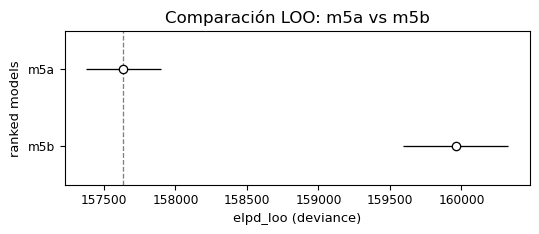

In [31]:
# ==============================
# Comparación de modelos m5a vs m5b
# --- 1) LOO individuales ---
loo_m5a = az.loo(idata_m5a, pointwise=True)
loo_m5b = az.loo(idata_m5b, pointwise=True)

print("== LOO individuales ==")
print("m5a:", loo_m5a)
print("m5b:", loo_m5b)

# --- 2) Comparación entre modelos (BB-pseudo-BMA sobre LOO) ---
cmp_loo = az.compare(
    {"m5a": idata_m5a, "m5b": idata_m5b},
    method="BB-pseudo-BMA",
    ic="loo",
    scale="deviance"
)
print("\n== Comparación (LOO) ==")
print(cmp_loo)

# --- 3) Gráfico de comparación ---
az.plot_compare(cmp_loo)
plt.title("Comparación LOO: m5a vs m5b")
plt.show()


Al imponer restricciones adicionales, el ajuste empeora, con predicciones no plausibles en municipios con pocos datos.

**Selección del modelo**

Se compararon los modelos m5a y m5b utilizando LOO (expected log predictive density). El modelo m5a obtuvo un elpd_loo ≈ –78,817, mientras que m5b alcanzó –79,979. Dado que valores menos negativos indican mejor capacidad predictiva, m5a muestra un ajuste superior. 

La diferencia en desempeño fue de aproximadamente 2,324 puntos a favor de m5a, con un error estándar cercano a 300. Esto significa que la ventaja de m5a es estadísticamente robusta y no atribuible al azar. 

Además, m5a es más parsimonioso (p_loo ≈ 316 vs 347 en m5b), lo que implica menor complejidad efectiva del modelo. Ambos modelos presentaron diagnósticos de Pareto k adecuados (100% en rango <0.7), por lo que las métricas son confiables. 

En resumen, m5a es el modelo claramente superior: predice mejor, es más simple y sus verificaciones PPC son plausibles. Por estas razones, se adopta m5a como modelo final para el análisis.
